<a href="https://colab.research.google.com/github/nnaemekaukpa/Leveraging-Deep-Learning-Architecture-for-Accurate-and-Efficient-Bone-Cancer-Detection-/blob/main/VGG_19_(resplit701515).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Importing the necessary libraries
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import image as mpimg
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataset = '/content/drive/MyDrive/bone cancer detection.v2i.folder/train'
valid_dataset = '/content/drive/MyDrive/bone cancer detection.v2i.folder/valid'
test_dataset = '/content/drive/MyDrive/bone cancer detection.v2i.folder/test'

In [ ]:
## function to list files and folder in the directory
def list_contents(directory):
  if os.path.exists(directory):
    print(f'contents of {directory}:')
    print(os.listdir(directory))
  else:
    print(f'{directory} does not exist')



In [ ]:
list_contents(train_dataset)
list_contents(valid_dataset)
list_contents(test_dataset)

contents of /content/drive/MyDrive/bone cancer detection.v2i.folder/train:
['normal', 'cancer']
contents of /content/drive/MyDrive/bone cancer detection.v2i.folder/valid:
['cancer', 'normal']
contents of /content/drive/MyDrive/bone cancer detection.v2i.folder/test:
['normal', 'cancer']


In [ ]:
def count_files(directory):
  if os.path.exists(directory):
    classes=[i for i in os.listdir(directory) if os.path.isdir(os.path.join(directory, i))]
    total_files=sum([len(files) for _,_,files in os.walk(directory)])
    print(f'found {total_files} images belonging to {len(classes)} classes.')
  else:
    print(f'{directory} does not exist')

In [ ]:
# Function to load data from the given directory
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

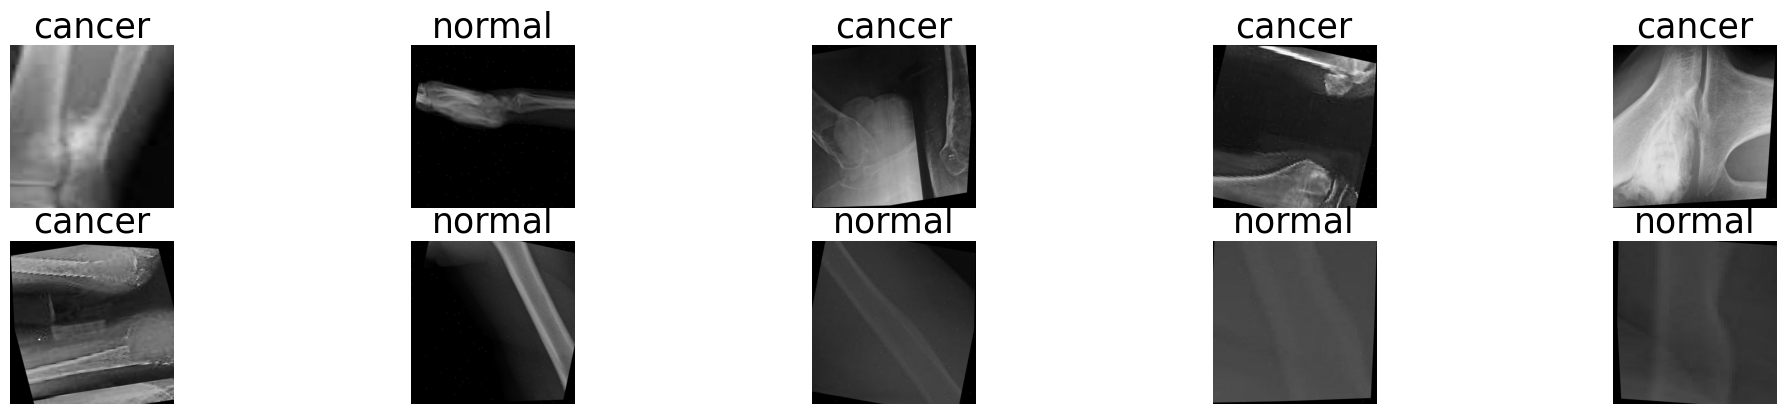

In [ ]:
import pandas as pd
# Load data into a DataFrame
train_df = data(train_dataset)
plt.figure(figsize=(25, 25))
for n, i in enumerate(np.random.randint(0, len(train_df), 10)):
    plt.subplot(10, 5, n + 1)
    img = cv2.imread(train_df.image[i])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(train_df.label[i], fontsize=25)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image and batch sizes
image_size = (224, 224)
batch_size = 32

# Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test data
test_val_datagen = ImageDataGenerator(rescale=1./255)

#  Training generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    directory=train_dataset
)

valid_df = data(valid_dataset)
#  Validation generator
valid_generator = test_val_datagen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    directory=valid_dataset
)
test_df = data(test_dataset)
#  Test generator
test_generator = test_val_datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    directory=test_dataset
)


Found 17617 validated image filenames belonging to 2 classes.
Found 2643 validated image filenames belonging to 2 classes.
Found 2643 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load the pre-trained VGG19 model without the top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to retain pre-trained weights
base_model.trainable = False

# Add custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
#model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Display model summary
#model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.metrics import AUC, SpecificityAtSensitivity

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        AUC(name='auc'),
        SpecificityAtSensitivity(0.9, name='specificity_at_sensitivity')
    ]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,480,193 (101.01 MB)

 Trainable params: 6,455,809 (24.63 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=valid_generator.samples // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 4333s 8s/step - accuracy: 0.6868 - auc: 0.7395 - loss: 0.5934 - specificity_at_sensitivity: 0.3667 - val_accuracy: 0.7915 - val_auc: 0.8946 - val_loss: 0.4310 - val_specificity_at_sensitivity: 0.6784
Epoch 2/10
  1/550 ━━━━━━━━━━━━━━━━━━━━ 1:38 180ms/step - accuracy: 0.6875 - auc: 0.8500 - loss: 0.6084 - specificity_at_sensitivity: 0.7727

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


550/550 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.6875 - auc: 0.8500 - loss: 0.6084 - specificity_at_sensitivity: 0.7727 - val_accuracy: 0.7961 - val_auc: 0.8949 - val_loss: 0.4238 - val_specificity_at_sensitivity: 0.6839
Epoch 3/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 383s 608ms/step - accuracy: 0.7774 - auc: 0.8544 - loss: 0.4700 - specificity_at_sensitivity: 0.6021 - val_accuracy: 0.8125 - val_auc: 0.9055 - val_loss: 0.3991 - val_specificity_at_sensitivity: 0.7050
Epoch 4/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.6562 - auc: 0.8706 - loss: 0.4789 - specificity_at_sensitivity: 0.3333 - val_accuracy: 0.8045 - val_auc: 0.9053 - val_loss: 0.4000 - val_specificity_at_sensitivity: 0.6987
Epoch 5/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 314s 570ms/step - accuracy: 0.7942 - auc: 0.8703 - loss: 0.4490 - specificity_at_sensitivity: 0.6426 - val_accuracy: 0.8270 - val_auc: 0.9155 - val_loss: 0.3674 - val_specificity_at_sensitivity: 0.7199
Epoch 6/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 17s 30m

In [ ]:
hist_=pd.DataFrame(history.history)
hist_

,accuracy,auc,loss,specificity_at_sensitivity,val_accuracy,val_auc,val_loss,val_specificity_at_sensitivity
0,0.735456,0.799295,0.536216,0.482251,0.791540,0.894580,0.430993,0.678404
1,0.687500,0.850000,0.608362,0.772727,0.796113,0.894914,0.423803,0.683881
2,0.783395,0.859750,0.460610,0.617371,0.812500,0.905506,0.399050,0.705008
3,0.656250,0.870588,0.478917,0.333333,0.804497,0.905350,0.399975,0.698748
4,0.797498,0.874253,0.438275,0.649625,0.826982,0.915548,0.367383,0.719875
5,0.875000,0.939216,0.339828,0.800000,0.828506,0.915338,0.366588,0.722222
6,0.801024,0.884916,0.417620,0.662515,0.822027,0.915814,0.364487,0.721440
7,0.875000,0.943750,0.332738,0.900000,0.819360,0.915695,0.364429,0.717527
8,0.807563,0.892000,0.408247,0.672153,0.819360,0.921857,0.352583,0.733959
9,0.843750,0.904762,0.435618,0.571429,0.820503,0.921829,0.351589,0.736307


## Performance Metrics curves

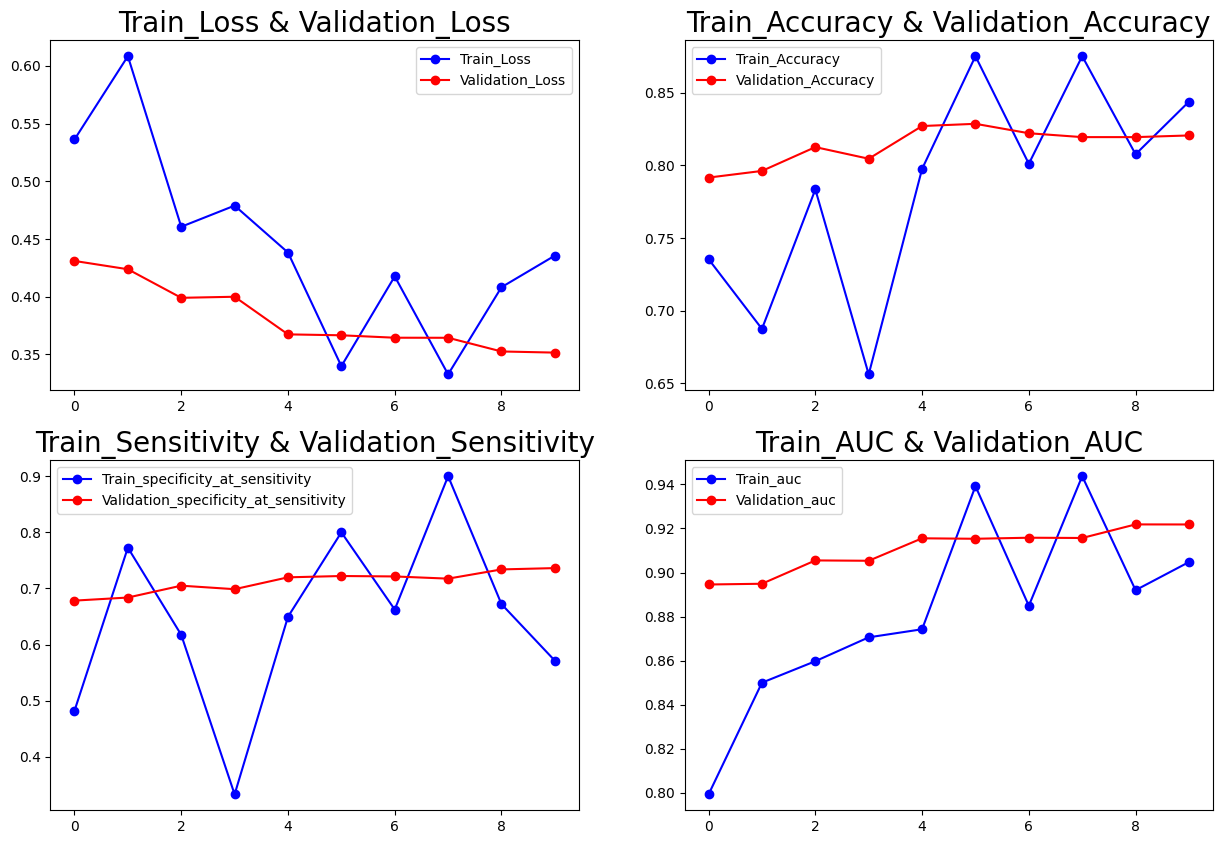

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.subplot(2,2,3)
plt.plot(hist_['specificity_at_sensitivity'],'b-o',label='Train_specificity_at_sensitivity')
plt.plot(hist_['val_specificity_at_sensitivity'],'r-o',label='Validation_specificity_at_sensitivity')
plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
plt.legend()
plt.subplot(2,2,4)
plt.plot(hist_['auc'],'b-o',label='Train_auc')
plt.plot(hist_['val_auc'],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 1068s 13s/step


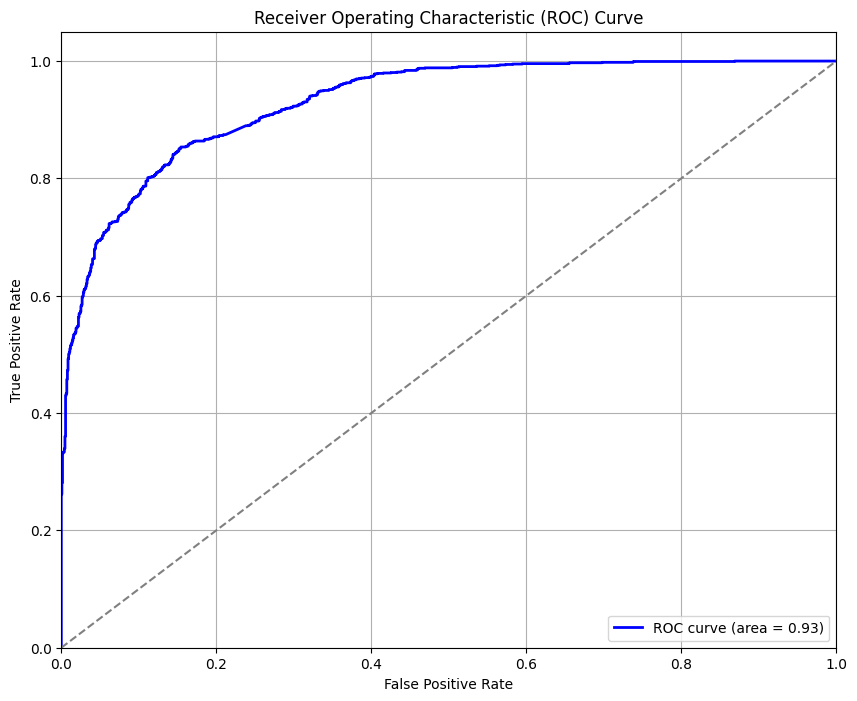

ROC AUC Score: 0.93


In [ ]:
# Calculate ROC curve and AUC
from sklearn.metrics import roc_curve, roc_auc_score

y_true = test_generator.labels
y_pred_probs = model.predict(test_generator)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = roc_auc_score(y_true, y_pred_probs)

## ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
print(f'ROC AUC Score: {roc_auc:.2f}')

In [ ]:
# Evaluate the model
test_results = model.evaluate(test_generator, verbose=1)
test_loss = test_results[0]  # Loss is the first element
test_accuracy = test_results[1]
test_auc = test_results[2]  # AUC is the third element
test_specificity_at_sensitivity = test_results[3]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Specificity at Sensitivity: {test_specificity_at_sensitivity:.4f}") # Added line

83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 228ms/step - accuracy: 0.8786 - auc: 0.4527 - loss: 0.2948 - specificity_at_sensitivity: 0.3594
Test Loss: 0.3374
Test Accuracy: 82.52%
Test AUC: 0.9302
Test Specificity at Sensitivity: 0.7421


In [ ]:
# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.where(y_pred > 0.5, 1, 0)
y_test = test_generator.labels


83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step


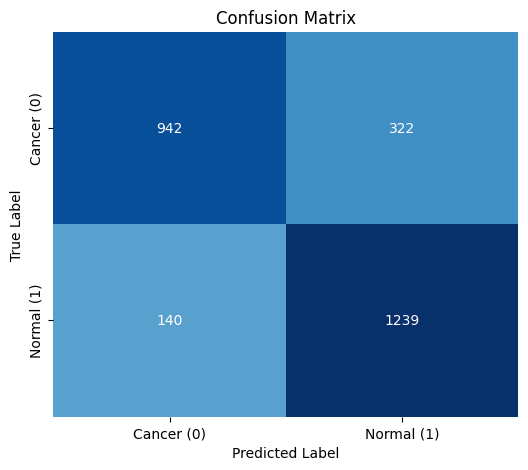

Classification Report:
               precision    recall  f1-score   support

  Cancer (0)       0.87      0.75      0.80      1264
  Normal (1)       0.79      0.90      0.84      1379

    accuracy                           0.83      2643
   macro avg       0.83      0.82      0.82      2643
weighted avg       0.83      0.83      0.82      2643



In [ ]:
# Confusion Matrix
CM = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(CM, fmt='g', center=True, cbar=False, annot=True, cmap='Blues',
            xticklabels=['Cancer (0)', 'Normal (1)'],
            yticklabels=['Cancer (0)', 'Normal (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:\n', classification_report(y_test, y_pred_classes, target_names=['Cancer (0)', 'Normal (1)']))


83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step


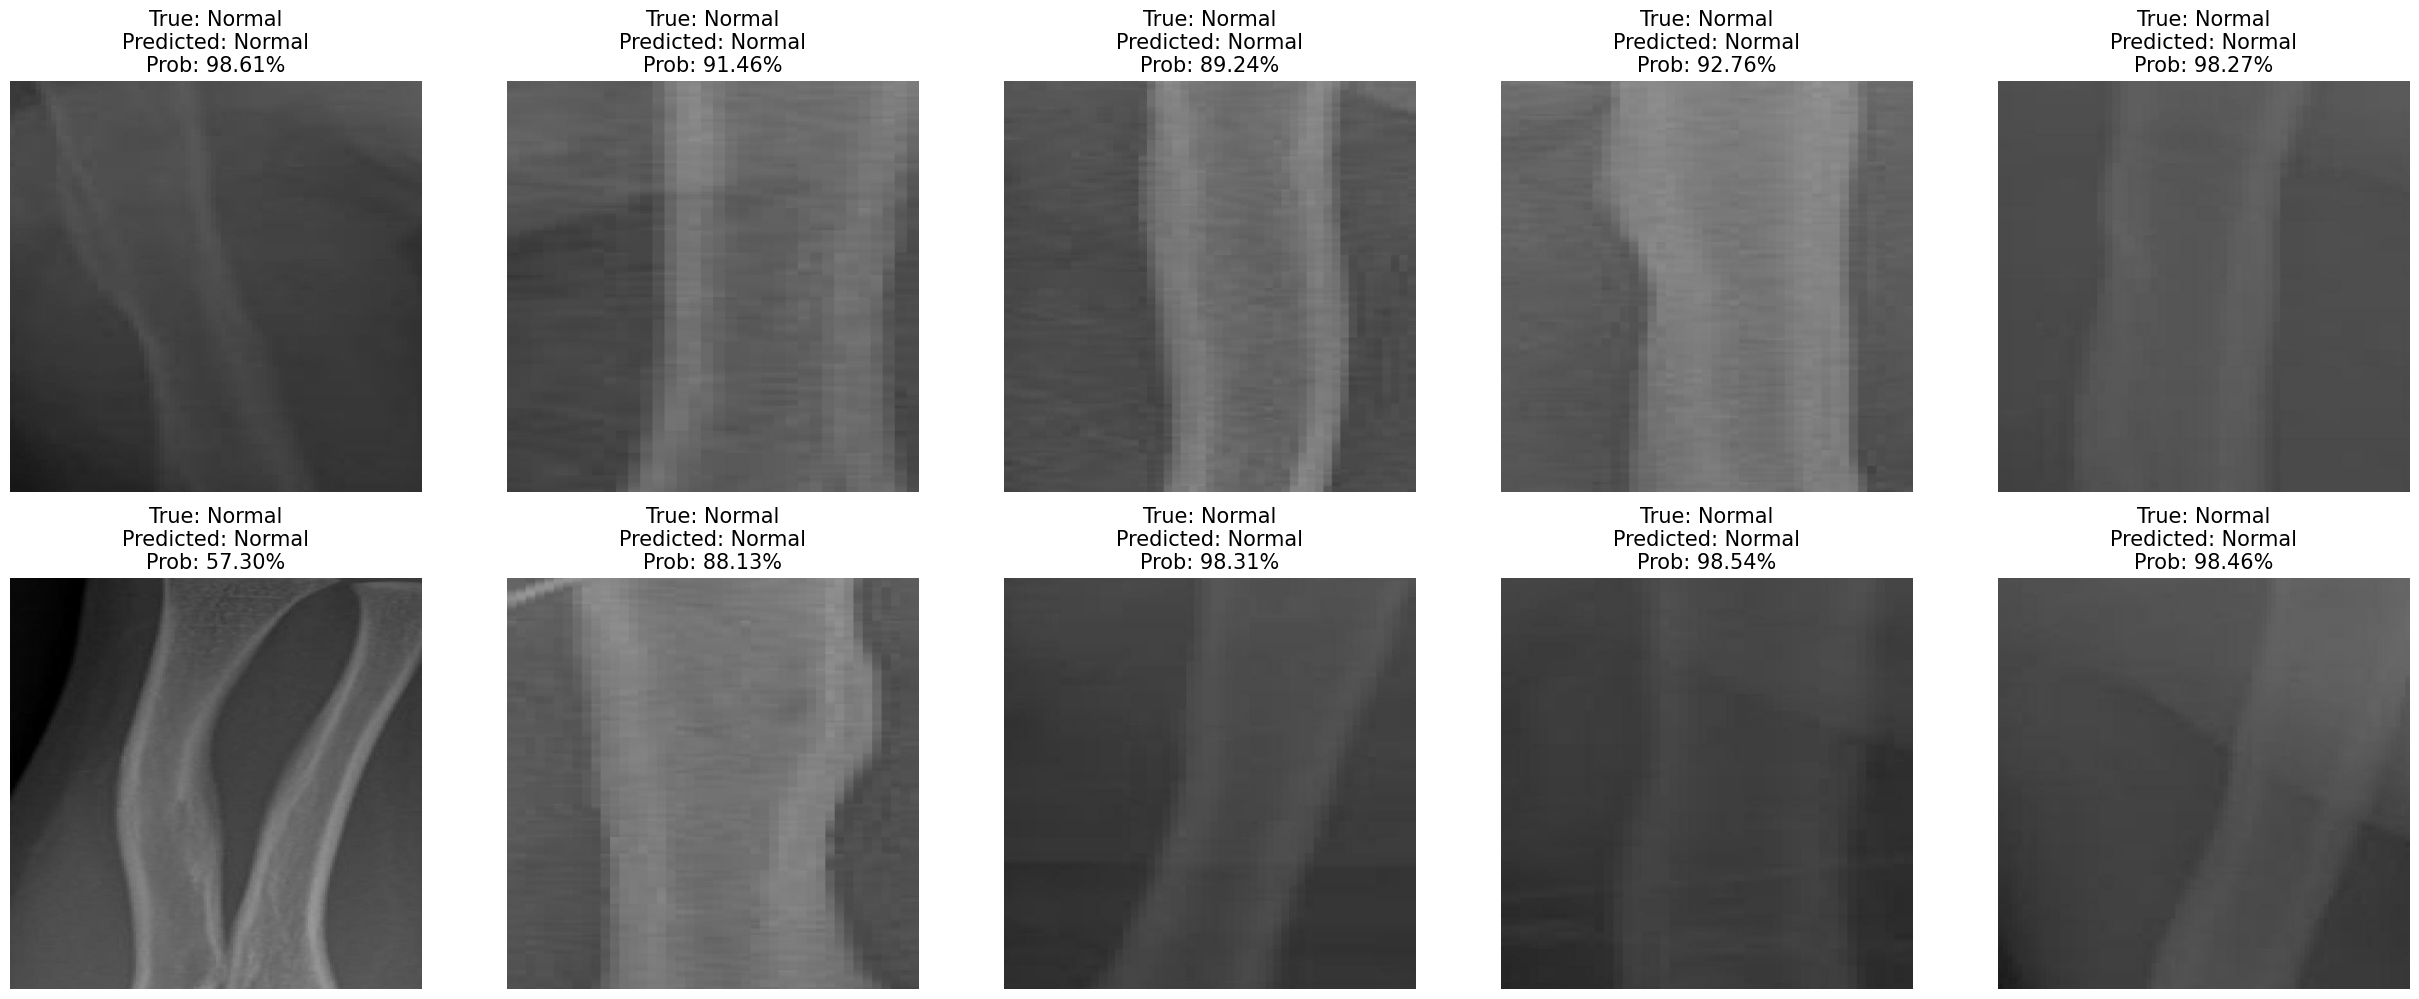

In [ ]:
# Function to display predictions
def display_predictions(model, test_generator, num_images=10):
    plt.figure(figsize=(25, 25))

    true_labels = test_generator.labels
    file_paths = test_generator.filepaths

    predictions = model.predict(test_generator).ravel()
    predicted_classes = (predictions > 0.5).astype(int)

    indices = np.random.randint(0, len(test_generator), num_images)

    for i, idx in enumerate(indices):
        img = cv2.imread(file_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(num_images // 2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')

        true_label = "Cancer" if true_labels[idx] == 0 else "Normal"
        predicted_label = "Cancer" if predicted_classes[idx] == 0 else "Normal"
        probability = predictions[idx] * 100

        plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nProb: {probability:.2f}%', fontsize=15)

    plt.tight_layout()
    plt.show()

# Display some predictions
display_predictions(model, test_generator, num_images=10)
